# Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/DeryFerd/Machine-Learning-Project/refs/heads/main/Data%20Sources/NFLX.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


Business Understanding

Business Understanding:

Netflix is one of the world’s leading streaming platforms, and its stock price often fluctuates based on a variety of factors such as financial performance, market sentiment, and competition within the industry. For investors and market analysts, being able to anticipate changes in Netflix's stock price can provide a valuable edge in making informed decisions. This dataset covers five years of daily trading data, from February 5, 2018, to February 5, 2022, including key indicators such as opening price, closing price, daily highs and lows, and trading volume.

Project Objective:

The goal of this project is to develop a predictive model for Netflix’s stock price using the Long Short-Term Memory (LSTM) algorithm — a type of recurrent neural network known for its strength in handling time series data. By learning patterns from historical stock prices, the LSTM model aims to generate accurate forecasts that could assist investors and analysts in identifying trends and planning investment strategies more effectively.

#Explore Data (EDA)

In [ ]:
df['Close'].describe()


,Close
count,1009.000000
mean,419.000733
std,108.289999
min,233.880005
25%,331.619995
50%,378.670013
75%,509.079987
max,691.690002


We’ll focus on Netflix’s closing price, since it’s a commonly used reference for predicting stock movements and shows where the market settled each day.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()


converts the 'Date' column to datetime format, sets it as the index, and sorts the data by date.

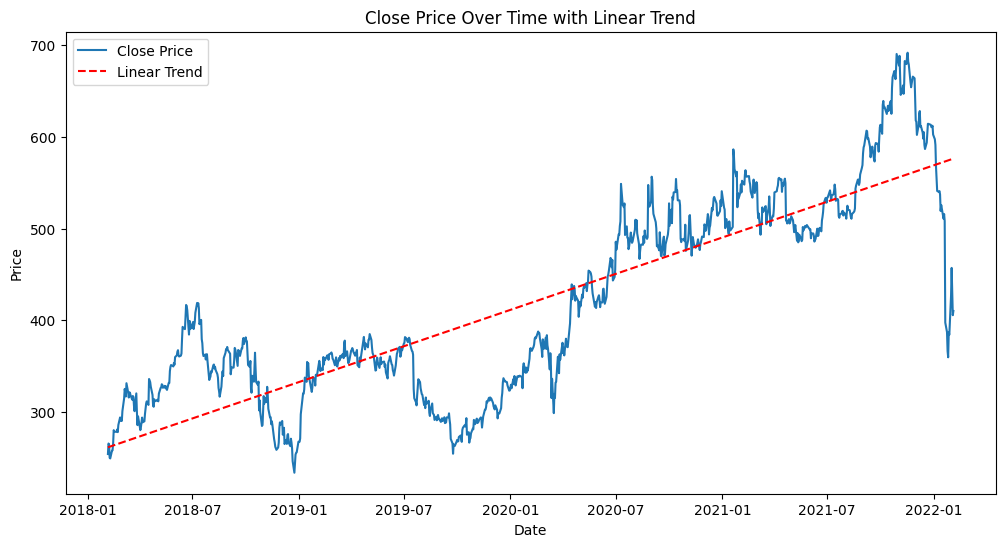

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the index is datetime and reset to use numeric x-axis
df = df.copy()
df = df.reset_index()

# Convert dates to numerical values for fitting
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

# Fit a linear trend line: y = m*x + b
m, b = np.polyfit(df['Date_ordinal'], df['Close'], 1)
trend = m * df['Date_ordinal'] + b

# Plot the original close price and trend line
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], trend, color='red', linestyle='--', label='Linear Trend')
plt.title('Close Price Over Time with Linear Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The chart shows the historical closing price of Netflix stock from early 2018 to early 2022, along with a linear trend line. Overall, there's a clear upward trajectory, indicating long-term growth in the stock price. Despite some short-term fluctuations, including noticeable dips in 2019 and mid-2020, the general trend remained positive until it peaked in late 2021.

The red dashed line represents a linear trend that captures the overall growth direction, though it doesn’t reflect the short-term volatility. After reaching its highest point in 2021, the price experienced a sharp decline at the beginning of 2022, highlighting increased volatility and potential market corrections. This kind of pattern suggests that while long-term investment in Netflix stock may have been profitable during this period, it also involved significant short-term risk.

In [ ]:
df['Close'].isna().sum()


np.int64(0)

It seems that no missing values are found in the 'Close' price column so we can continue to preprocessing the data step.

# Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Only keep the 'Close' column
close_data = df['Close'].values.reshape(-1, 1)

# Scale to [0, 1]
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_data)


The 'Close' column is selected and reshaped to a 2D array, then scaled to a range between 0 and 1 using MinMaxScaler to normalize the values for better performance in training the LSTM model.

##Train-Test Split Dataset

In [ ]:
train_size = int(len(scaled_close) * 0.8)
train_data = scaled_close[:train_size]
test_data = scaled_close[train_size:]


Split the dataset to 80% as train set and 20% as test set.

##LTSM Sequences

In [ ]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # previous 'time_steps' values
        y.append(data[i, 0])              # current value
    return np.array(X), np.array(y)

# 60 timesteps is common
X_train, y_train = create_sequences(train_data, 60)
X_test, y_test = create_sequences(test_data, 60)


The create_sequences function transforms time series data into input sequences (X) using a window of past time_steps to predict the immediate next value (y), preparing it for supervised learning. Applying this with a 60-timestep window to train_data and test_data respectively generates the X_train, y_train and X_test, y_test datasets for model training and evaluation.

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


The X_train and X_test arrays are being reshaped to add an additional dimension, typically required by recurrent neural network layers like LSTMs; this new dimension usually signifies that each time step in the sequence has one feature.

#Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Output layer


A neural network model is being assembled by stacking layers: it begins with two LSTM layers, each containing 50 "memory units" to learn patterns from the sequential input data (the first LSTM passes its full sequence output to the second), and then a final Dense layer with one neuron produces the actual prediction.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0747 - val_loss: 0.0427
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0

The model.fit() function trains the neural network using your X_train and y_train data for 20 complete passes (epochs), processing 32 samples at a time (batch_size). The output shows that for each epoch, the model's training error (loss) generally decreases, while the val_loss indicates how well it performs on unseen test data, helping to monitor for overfitting.

#Evaluation

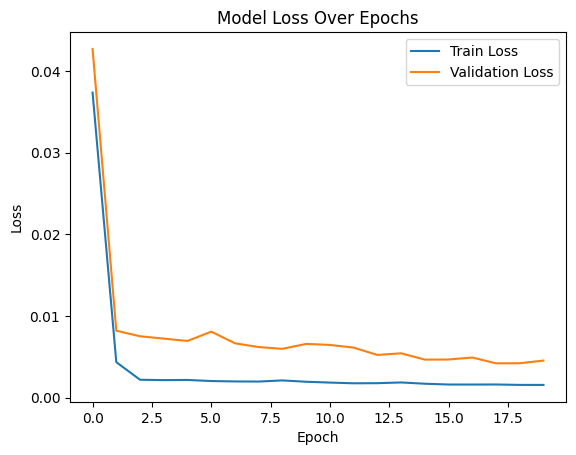

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


This graph plots how the model's error (loss) changes as it trains over several cycles (epochs), both for the data it's learning from (Train Loss, blue) and for new, unseen data (Validation Loss, orange). Both errors decrease quickly at first, but the training error continues to get very low while the validation error plateaus at a slightly higher level, suggesting the model is learning effectively but might be starting to perform better on the training data than on new data (a sign of potential slight overfitting).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict
predicted_scaled = model.predict(X_test)

# Inverse transform to original price scale
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)

print(f'MSE : {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
MSE : 951.18
RMSE: 30.84
MAE : 23.45


MSE (Mean Squared Error): 951.18

This value represents the average of the squared differences between the predicted and actual values. In this case, an MSE of 951.18 reflects the magnitude of the discrepancy between the predicted and actual stock prices.

RMSE (Root Mean Squared Error): 30.84

The square root of MSE, providing an error estimate in the same units as the data (e.g., dollars). This suggests that the predictions deviate by about 30.84 units on average.

MAE (Mean Absolute Error): 23.45

The average absolute difference between predicted and actual values. A lower MAE means better accuracy. The model's predictions deviate by about 23.45 units on average.

#Forecast

In [ ]:
# Predict on test data
predicted_scaled = model.predict(X_test)

# Inverse transform to original scale
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


We will forecast our dataset and compare it with the actual prices.

In [ ]:
# Use test portion of the original dates, adjusted for the 60-step offset
prediction_dates = df.index[-len(actual):]


The line selects the last len(actual) dates from the dataframe's index, aligning them with the actual test data. The -len(actual) ensures the selection corresponds to the most recent dates, adjusting for the 60-step offset. This ensures the forecasted dates match the actual test data's time periods.

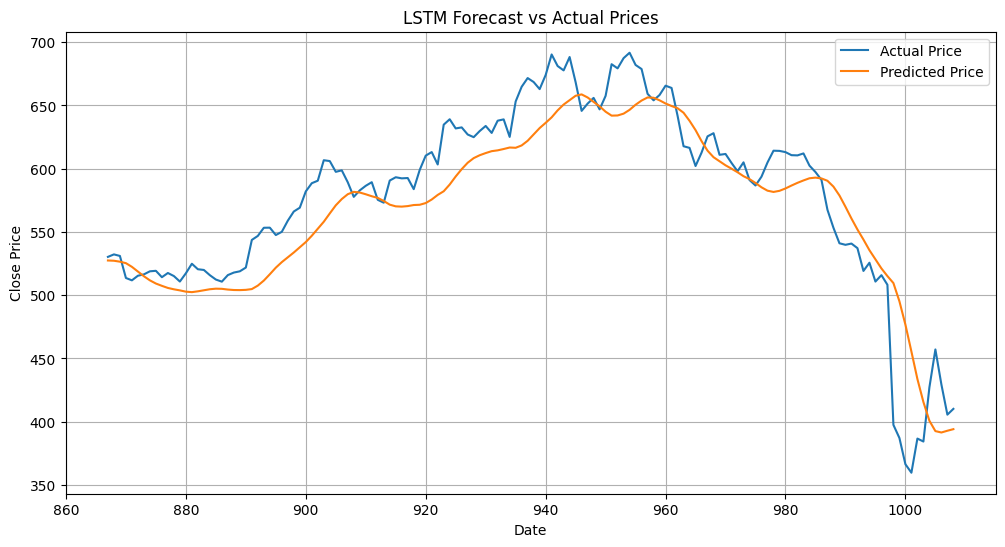

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(prediction_dates, actual, label='Actual Price')
plt.plot(prediction_dates, predicted, label='Predicted Price')
plt.title('LSTM Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


This graph displays the LSTM model's predicted stock prices (orange line) against the actual prices (blue line) over time. The model successfully captures the general directional trends of the actual prices. However, the predicted line is considerably smoother, indicating it doesn't fully capture the sharp peaks and valleys, suggesting it's better at predicting overall movements than high-frequency volatility.